In [1]:
import EITfunc.EITlook as eit
import spotchaos.syntheticSignals as sp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os
import itertools
import copy

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
from scipy.ndimage import median_filter, gaussian_filter

import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#columns:
#t_obs[JD] flux[normalized] flux_unc[normalized]
#days without observations have flux=nan, fluxerr=nan
virgo = np.genfromtxt("./VIRGO_LC_norm.txt")
#print(virgo)
print(np.shape(virgo))

#start time at 0
virgo[:,0] = virgo[:,0] - virgo[0,0]

(10129, 3)


In [3]:
noObs = np.isnan(virgo[:,1])
n_noObs = len(virgo[:,0][noObs])
print(n_noObs)
dutyCycle = n_noObs/len(virgo)
print(dutyCycle)

210
0.02073255010366275


In [4]:
#linearly interpolate missing data points (for now)
def linearlyInterpolateGaps(t, f, ferr):
    f = copy.deepcopy(f)
    ferr = copy.deepcopy(ferr)
    noObs = np.isnan(f)
    noObsIdxs = np.arange(len(t))[noObs]
    obsIdxs = np.arange(len(t))[~noObs]
    for i in noObsIdxs:
        prevGood = obsIdxs[obsIdxs <= i][-1]
        nextGood = obsIdxs[obsIdxs > i][0]
        #print(prevGood, i, nextGood)
        f[i] = f[prevGood] + ((t[i] - t[prevGood])/(t[nextGood]-t[prevGood]))*(f[nextGood] - f[prevGood])
        ferr[i] = np.abs(f[prevGood] - f[nextGood]) + 2*np.max((ferr[prevGood],ferr[nextGood]))
    return f, ferr

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    

In [5]:
f, ferr = linearlyInterpolateGaps(virgo[:,0], virgo[:,1], virgo[:,2])

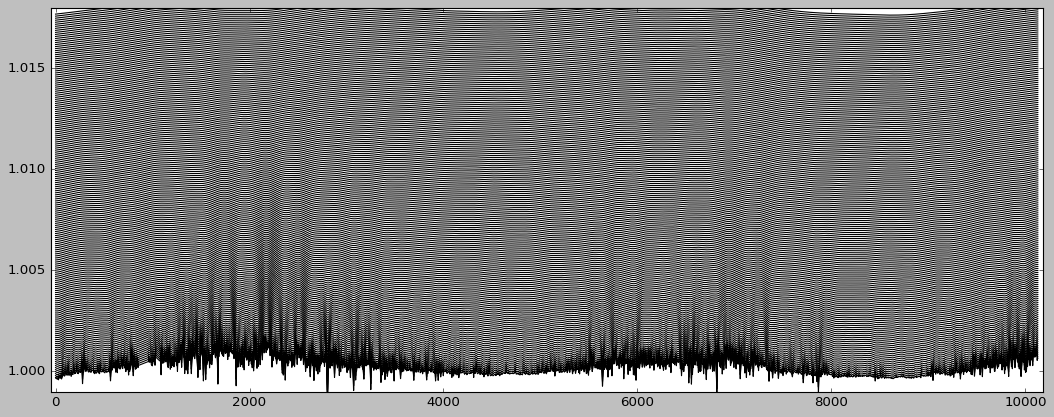

In [68]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
for s in range(1,181,1):
    f_gsmoothed = gaussian_filter(f,sigma=s,mode='nearest')
    ax.plot(virgo[:,0],f_gsmoothed+(s/10000),'k-',alpha=1)
ax.set_xlim(virgo[0,0]-50, virgo[-1,0]+50)
ax.set_ylim(1.-0.001,1+0.018)
plt.show()

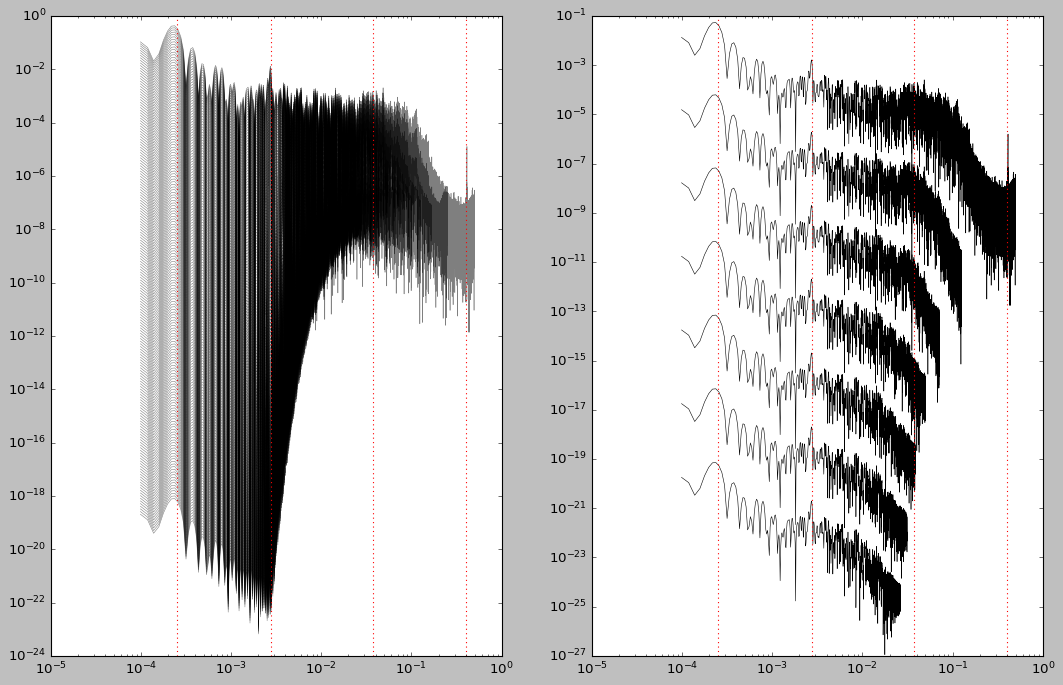

In [99]:
fig, axes = plt.subplots(1,2,figsize=(16,10))
for s in range(1,181,1):
    f_gsmoothed = gaussian_filter(f,sigma=s,mode='nearest')
    freq_smooth, pow_smooth= LombScargle(virgo[:,0],f_gsmoothed).autopower(minimum_frequency=(1./np.ptp(virgo[:,0])), maximum_frequency=(1./(2.*s)))
    axes[0].plot(freq_smooth,pow_smooth*10**(-s/10),'k-',lw=0.5,alpha=0.5)
    if s < 21 and s%3==1:
        axes[1].plot(freq_smooth,pow_smooth*10**(-s),'k-',lw=0.5,alpha=1)
for ax in axes:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.axvline(1./(365.*11),color='r',ls=':')
    ax.axvline(1./365,color='r',ls=':')
    ax.axvline(1./27.,color='r',ls=':')
    ax.axvline(1./2.5,color='r',ls=':')
plt.show()

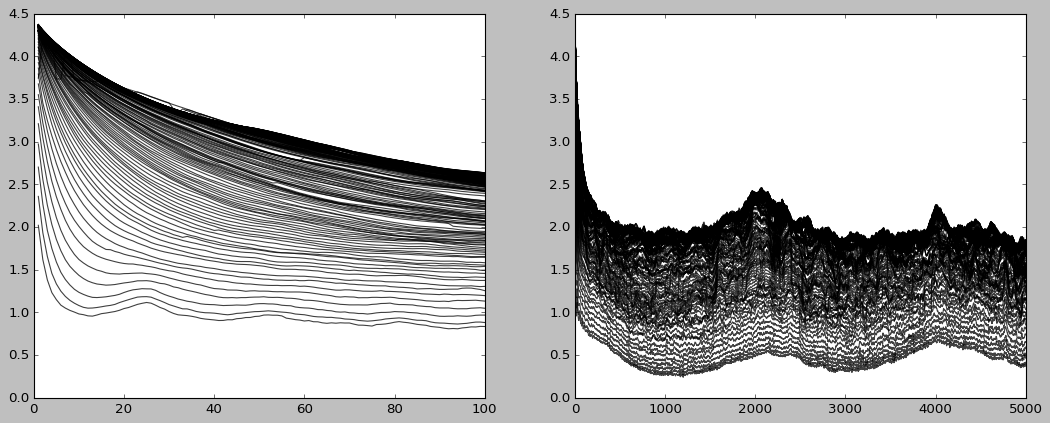

In [67]:
trialDelayIndices = np.arange(1,5001,1)
fig, axes = plt.subplots(1,2,figsize=(16,6))
for s in range(1,181,1):
    f_gsmoothed = gaussian_filter(f,sigma=s,mode='nearest')
    
    MI = np.zeros_like(trialDelayIndices,dtype='float')
    for i,tau in enumerate(trialDelayIndices):
        MI[i] = sp.calc_MI(f_gsmoothed[:-(tau+1)], f_gsmoothed[(tau+1):],Xbins=sp.optimal_Nbins(f_gsmoothed[:-(tau+1)]), Ybins = sp.optimal_Nbins(f_gsmoothed[(tau+1):]))
    
    axes[0].plot(trialDelayIndices,MI+(s/10000),'k-',alpha=0.75)
    axes[1].plot(trialDelayIndices,MI+(s/10000),'k-',alpha=0.75)

axes[0].set_xlim(0,100)
axes[1].set_xlim(0,5000)

plt.show()

In [6]:
#f = virgo[:,1]
#ferr = virgo[:,2]

f_smoothed_101 = median_filter(f,size=101,mode='nearest')
f_smoothed_1001 = median_filter(f,size=1001,mode='nearest')

medium_smoothing_sigma = 27.
extreme_smoothing_sigma = 178.

f_gsmoothed_101 = gaussian_filter(f,sigma=medium_smoothing_sigma,mode='nearest')
f_gsmoothed_1001 = gaussian_filter(f,sigma=extreme_smoothing_sigma,mode='nearest')

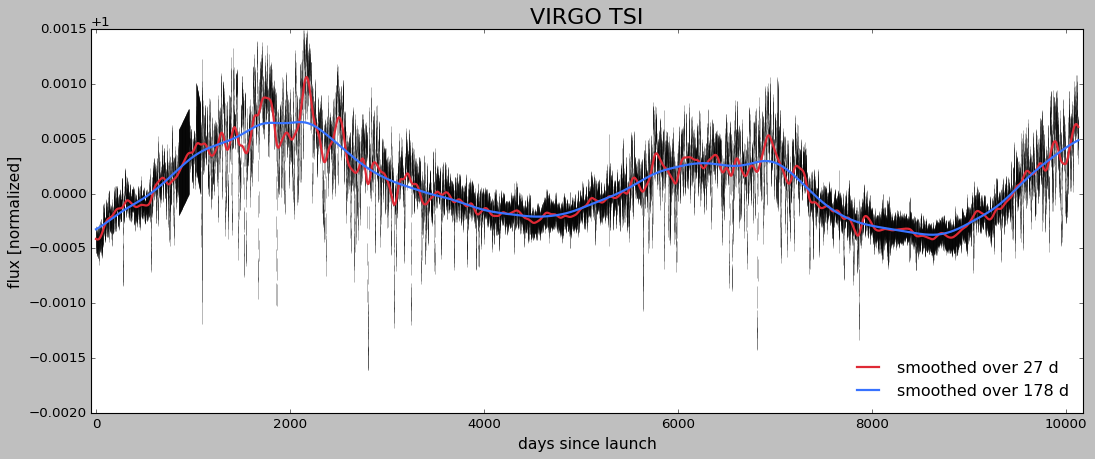

In [7]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(virgo[:,0], f, yerr=ferr, marker='None',color='k',ls='None',capsize=0, elinewidth=0.5,alpha=0.5)
#ax.plot(virgo[:,0],f_smoothed_101,'r-',lw=2)
#ax.plot(virgo[:,0],f_smoothed_1001,'b-',lw=1)

ax.plot(virgo[:,0],f_gsmoothed_101,ls='-',color='#df2935',lw=2,label="smoothed over 27 d")
ax.plot(virgo[:,0],f_gsmoothed_1001,ls='-',color='#3772ff',lw=2,label="smoothed over 178 d")

ax.set_xlim(virgo[0,0]-50, virgo[-1,0]+50)
ax.legend(loc='lower right',frameon=False)
ax.set_xlabel("days since launch",fontsize=14)
ax.set_ylabel("flux [normalized]",fontsize=14)
ax.set_title("VIRGO TSI",fontsize=20)
#ax.set_xlim(0,500)
plt.savefig("./VIRGO_LC_smoothed.pdf")

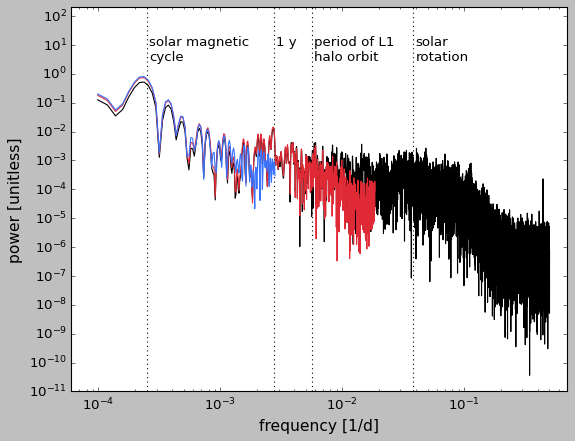

In [12]:
freq, pow = LombScargle(virgo[:,0][~noObs],virgo[:,1][~noObs],virgo[:,2][~noObs]).autopower(minimum_frequency=(1./np.ptp(virgo[:,0][~noObs])), maximum_frequency=(1./2.))
freq_smooth, pow_smooth= LombScargle(virgo[:,0][~noObs],f_gsmoothed_101[~noObs],virgo[:,2][~noObs]).autopower(minimum_frequency=(1./np.ptp(virgo[:,0])), maximum_frequency=(1./(2.*medium_smoothing_sigma)))
freq_smooth2, pow_smooth2= LombScargle(virgo[:,0][~noObs],f_gsmoothed_1001[~noObs],virgo[:,2][~noObs]).autopower(minimum_frequency=(1./np.ptp(virgo[:,0])), maximum_frequency=(1./(2.*extreme_smoothing_sigma)))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(freq,pow,'k-')
ax.plot(freq_smooth,pow_smooth,ls='-',color='#df2935',lw=1)
ax.plot(freq_smooth2,pow_smooth2,ls='-',color='#3772ff',lw=1)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(0.,0.01)
#ax.set_ylim(0.,0.6)


ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
ax.axvline(1./(11*365.),color='k',ls=':',zorder=1) #magnetic cycle

ax.text(1.05/26.24, 3.e0, 'solar'+'\n'+'rotation',fontsize=12)
ax.text(1.05/178., 3.e0, 'period of L1'+'\n'+'halo orbit',fontsize=12)
ax.text(1.05/365., 1.e1, '1 y',fontsize=12)
ax.text(1.05/(365*11), 3.e0, 'solar magnetic'+'\n'+'cycle',fontsize=12)

ax.set_ylim(1.e-11,2.e2)
ax.set_xlim(6.e-5,7.e-1)

ax.set_xlabel("frequency [1/d]", fontsize=14)
ax.set_ylabel("power [unitless]", fontsize=14)


#plt.show()
plt.savefig("./VIRGO_LC_smoothed_periodogram.pdf",bbox_inches="tight")

In [38]:
trialDelayIndices = np.arange(1,6001,1)
MI = np.zeros_like(trialDelayIndices,dtype='float')
for i,tau in enumerate(trialDelayIndices):
    MI[i] = sp.calc_MI(f[:-(tau+1)], f[(tau+1):],Xbins=sp.optimal_Nbins(f[:-(tau+1)]), Ybins = sp.optimal_Nbins(f[(tau+1):]))

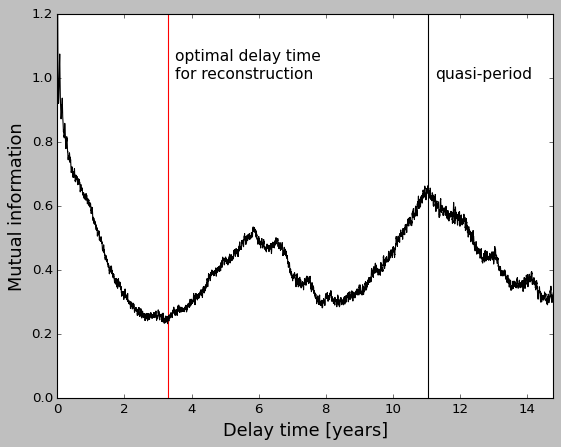

In [55]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(trialDelayIndices/365.25,MI,'k-',zorder=2)
ax.axvline(4037/365.25,color='k',ls='-',zorder=1)
ax.axvline(1200/365.25,color='r',ls='-',zorder=1)

ax.text(1280/365.25, 1, 'optimal delay time'+'\n'+'for reconstruction',fontsize=14)
ax.text(4117/365.25, 1, 'quasi-period',fontsize=14)
ax.set_xlim(0,5400/365.25)
ax.set_ylim(0,1.2)
ax.set_xlabel("Delay time [years]",fontsize=16)
ax.set_ylabel("Mutual information",fontsize=16)
#plt.show()
plt.savefig("VIRGO_magcycle_MI.pdf",bbox_inches="tight")

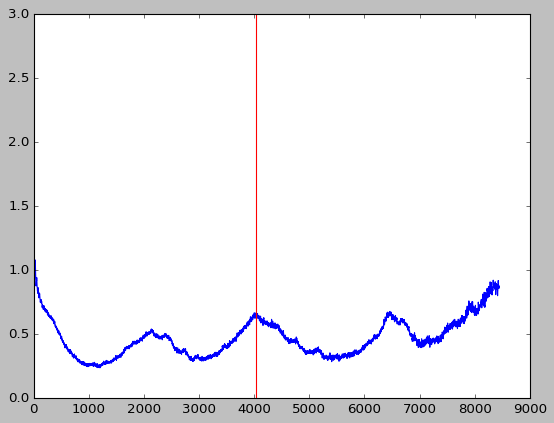

4037


In [26]:
qp_idx, MI = sp.estimateQuasiPeriod(time=virgo[:,0], timeSeries=f, method="power", plot=True, return_MI=True)
print(qp_idx)

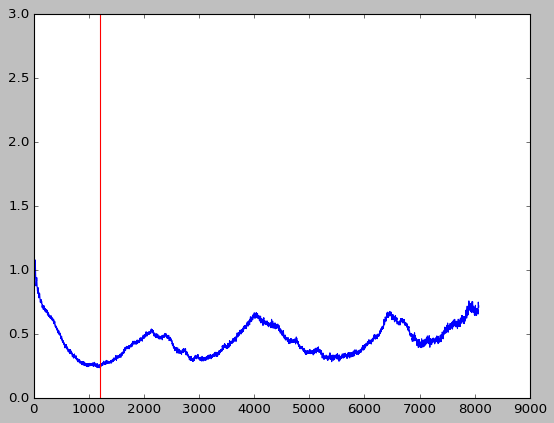

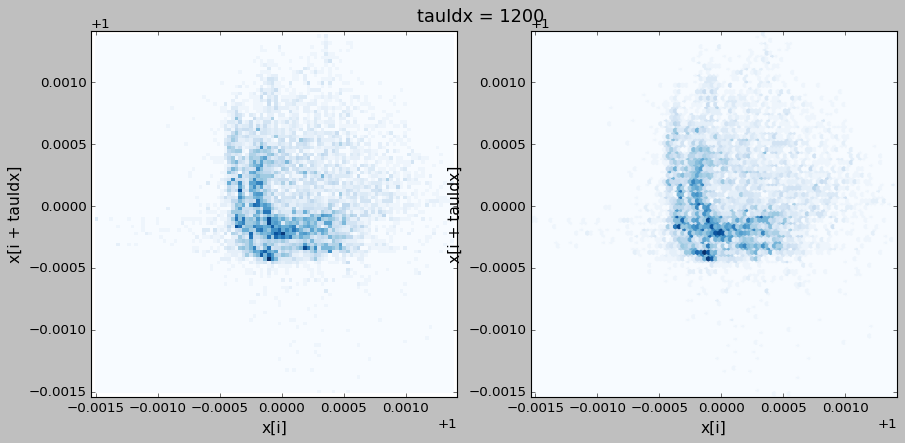

In [27]:
mutInfo, bestTauIdx, qp = sp.FS86(time = virgo[:,0], timeSeries = f, QPmethod="power", method="first_or_second_local_min", plot=True)
                

In [28]:
print(qp)
print(bestTauIdx)

4037
1200


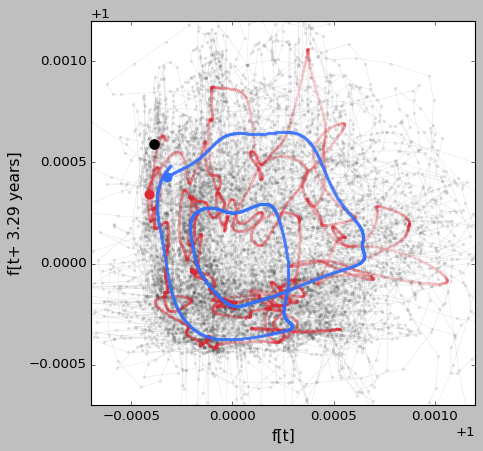

In [62]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(f[:-bestTauIdx],f[bestTauIdx:],marker='.',ms=6,mec='None',ls='-',color='k',lw=0.5,alpha=0.1)
ax.plot(f_gsmoothed_101[:-bestTauIdx],f_gsmoothed_101[bestTauIdx:],marker='.',ms=6,mec='None',ls='-',color='#df2935',lw=0.5,alpha=0.1)
ax.plot(f_gsmoothed_1001[:-bestTauIdx],f_gsmoothed_1001[bestTauIdx:],marker='.',ms=6,mec='None',ls='-',color='#3772ff',lw=0.5,alpha=0.1)

ax.plot(f[0],f[bestTauIdx],'ko',ms=9)
ax.plot(f_gsmoothed_101[0],f_gsmoothed_101[bestTauIdx],marker='o',color='#df2935',ms=9,mec='None')
ax.plot(f_gsmoothed_1001[0],f_gsmoothed_1001[bestTauIdx],marker='o',color='#3772ff',ms=9,mec='None')

ax.set_aspect('equal')
ax.set_xlabel(r"f[t]",fontsize=14)
ax.set_ylabel(r"f[t+ 3.29 years]",fontsize=14)
ax.set_xlim(1.-0.0007,1.0012)
ax.set_ylim(1.-0.0007,1.0012)
#plt.show()
plt.savefig("./VIRGO_magcycle_delayplot.pdf",bbox_inches="tight")

# Subtract off the 6-month-Gaussian-smoothed time series and see what happens

In [126]:
f_nomagcycle = f - f_gsmoothed_1001

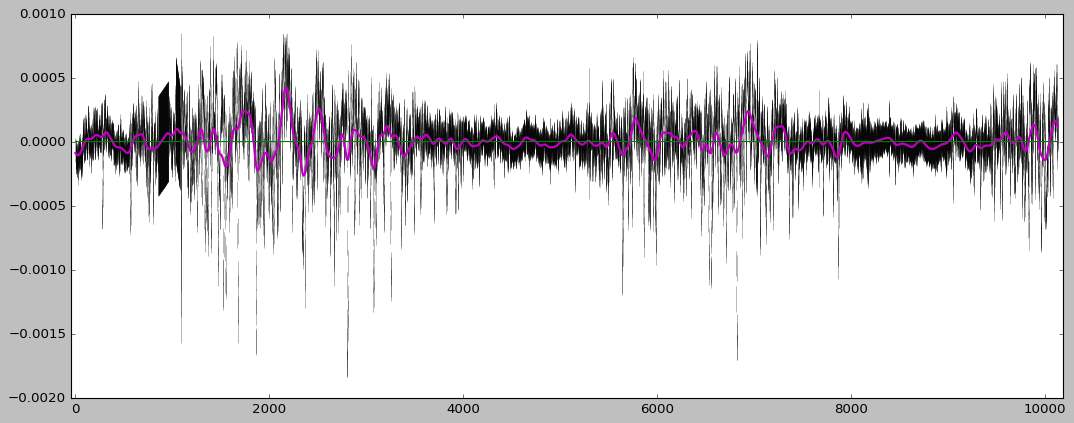

In [127]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(virgo[:,0], f_nomagcycle, yerr=ferr, marker='None',color='k',ls='None',capsize=0, elinewidth=0.5,alpha=0.5)

ax.plot(virgo[:,0],f_gsmoothed_101-f_gsmoothed_1001,'m-',lw=2)
ax.plot(virgo[:,0],f_gsmoothed_1001-f_gsmoothed_1001,'g-',lw=1)

ax.set_xlim(virgo[0,0]-50, virgo[-1,0]+50)
plt.show()

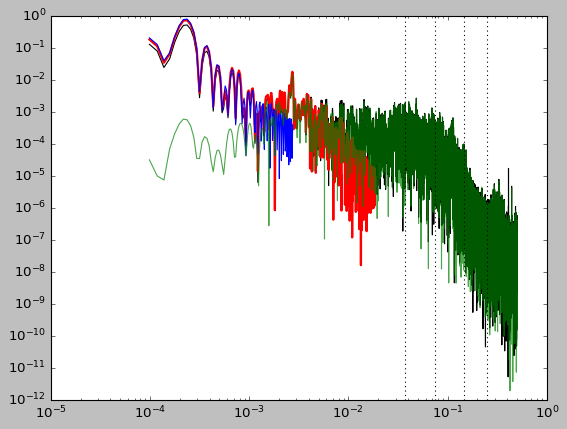

In [128]:
freq_nomagcycle, pow_nomagcycle = LombScargle(virgo[:,0],f_nomagcycle).autopower(minimum_frequency=(1./np.ptp(virgo[:,0])), maximum_frequency=(1./2.))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(freq,pow,'k-')

ax.plot(freq_smooth,pow_smooth,'r-',lw=2)
ax.plot(freq_smooth2,pow_smooth2,'b-',lw=1)
ax.plot(freq_nomagcycle,pow_nomagcycle*0.33,'g-',alpha=0.7)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(0.,0.01)
#ax.set_ylim(0.,0.6)
ax.axvline(1./27.,color='k',ls=":")
ax.axvline(2./27.,color='k',ls=":")
ax.axvline(4./27.,color='k',ls=":")
ax.axvline(1/4.,color='k',ls=":")
plt.show()

In [129]:
trialDelayIndices = np.arange(1,101,1)
MI = np.zeros_like(trialDelayIndices,dtype='float')
for i,tau in enumerate(trialDelayIndices):
    MI[i] = sp.calc_MI(f_nomagcycle[:-(tau+1)], f_nomagcycle[(tau+1):],Xbins=sp.optimal_Nbins(f_nomagcycle[:-(tau+1)]), Ybins = sp.optimal_Nbins(f_nomagcycle[(tau+1):]))

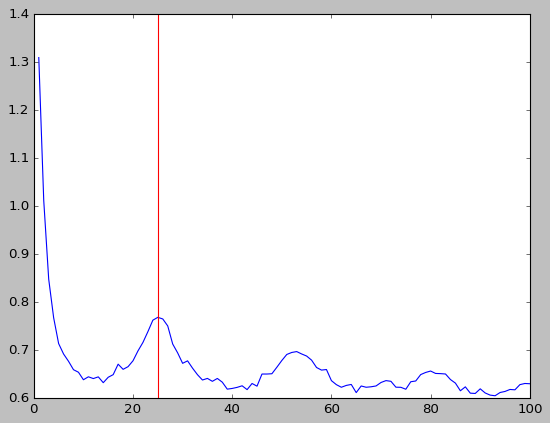

In [130]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(trialDelayIndices,MI,'b-')
ax.axvline(25,color='r')
#ax.set_xlim(0,500)
plt.show()

53


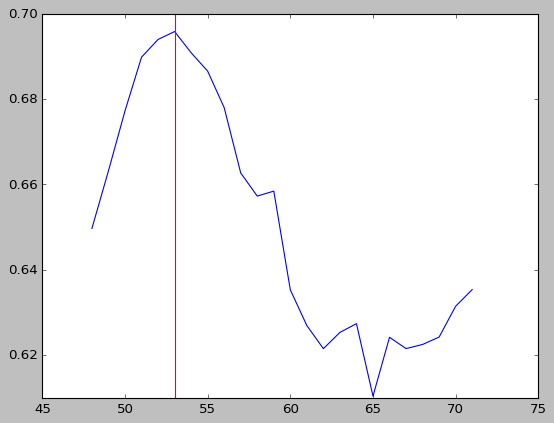

In [131]:
qp_idx, MI = sp.estimateQuasiPeriod(time=virgo[:,0], timeSeries=f_nomagcycle, method="localMaxSep", cwt_widths=np.arange(1,50),plot=True, return_MI=True)
print(qp_idx)

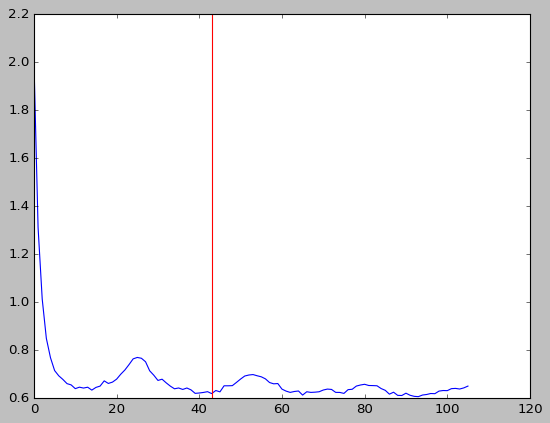

43
53


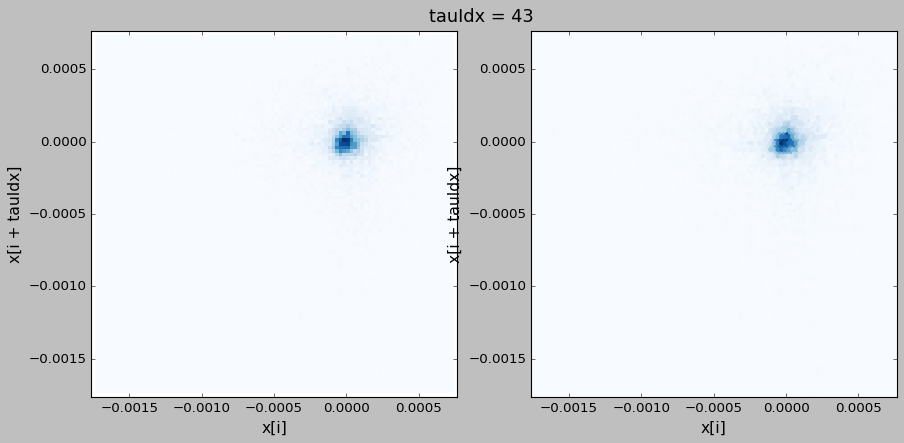

In [132]:
mutInfo, bestTauIdx, qp = sp.FS86(time = virgo[:,0], timeSeries = f_nomagcycle, QPmethod="localMaxSep", cwt_widths=np.arange(1,50), method="first_or_second_local_min", plot=True)
print(bestTauIdx)
print(qp)

In [133]:
print(len(f[:-bestTauIdx])/qp)
print(qp)

190.30188679245282
53


In [ ]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
    
#axes[0].errorbar(f[:-bestTauIdx],f[bestTauIdx:],xerr=ferr[:-bestTauIdx],yerr=ferr[bestTauIdx:],color='k',ls='-',lw=0.5,alpha=0.3,elinewidth=0.1,capsize=0,marker='None')
axes[0].errorbar(f_gsmoothed_101[:-bestTauIdx],f_gsmoothed_101[bestTauIdx:],xerr=ferr[:-bestTauIdx],yerr=ferr[bestTauIdx:],color='k',ls='-',lw=0.5,alpha=0.3,elinewidth=0.1,capsize=0,marker='None')
#axes[0].plot(f[0],f[bestTauIdx],'ko',ms=10)
#axes[0].plot(f_gsmoothed_101[0],f_gsmoothed_101[bestTauIdx],'ro',ms=5)
    
#axes[1].errorbar(f_nomagcycle[:-bestTauIdx],f_nomagcycle[bestTauIdx:],xerr=ferr[:-bestTauIdx],yerr=ferr[bestTauIdx:],color='k',ls='-',lw=0.5,alpha=0.3,elinewidth=0.1,capsize=0,marker='None')
axes[1].errorbar((f_gsmoothed_101-f_gsmoothed_1001)[:-bestTauIdx],(f_gsmoothed_101-f_gsmoothed_1001)[bestTauIdx:],xerr=ferr[:-bestTauIdx],yerr=ferr[bestTauIdx:],color='k',ls='-',lw=0.5,alpha=0.3,elinewidth=0.1,capsize=0,marker='None')
#axes[1].plot(f_nomagcycle[0],f_nomagcycle[0],'ko',ms=10)
#axes[1].plot((f_gsmoothed_101-f_gsmoothed_1001)[0],(f_gsmoothed_101-f_gsmoothed_1001)[bestTauIdx],'ro',ms=5)

axes[0].set_xlim(1-0.002,1+0.002)
axes[0].set_ylim(1-0.002,1+0.002)
axes[1].set_xlim(-0.002,0.002)
axes[1].set_ylim(-0.002,0.002)
    
for ax in axes:
    ax.set_aspect('equal')
plt.show()


In [136]:
for j in range(0,190):
    fig, axes = plt.subplots(1,2,figsize=(16,6))
    
    #axes[0].errorbar(f[:-bestTauIdx][0:j*qp],f[bestTauIdx:][0:j*qp],xerr=ferr[:-bestTauIdx][0:j*qp],yerr=ferr[bestTauIdx:][0:j*qp],color='k',ls='-',lw=0.5,alpha=0.3,elinewidth=0.1,capsize=0,marker='None')
    #axes[0].errorbar(f[:-bestTauIdx][j*qp:(j+1)*qp],f[bestTauIdx:][j*qp:(j+1)*qp],xerr=ferr[:-bestTauIdx][j*qp:(j+1)*qp],yerr=ferr[bestTauIdx:][j*qp:(j+1)*qp],color='k',ls='-',lw=0.5,alpha=1,elinewidth=0.1,capsize=0,marker='None')
    axes[0].errorbar(f_gsmoothed_101[:-bestTauIdx][0:j*qp],f_gsmoothed_101[bestTauIdx:][0:j*qp],xerr=ferr[:-bestTauIdx][0:j*qp],yerr=ferr[bestTauIdx:][0:j*qp],color='k',ls='-',lw=0.5,alpha=0.3,elinewidth=0.1,capsize=0,marker='None')
    axes[0].errorbar(f_gsmoothed_101[:-bestTauIdx][j*qp:(j+1)*qp],f_gsmoothed_101[bestTauIdx:][j*qp:(j+1)*qp],xerr=ferr[:-bestTauIdx][j*qp:(j+1)*qp],yerr=ferr[bestTauIdx:][j*qp:(j+1)*qp],color='k',ls='-',lw=0.5,alpha=1,elinewidth=0.1,capsize=0,marker='None')
    #axes[0].plot(f[0],f[bestTauIdx],'ko',ms=10)
    #axes[0].plot(f_gsmoothed_101[0],f_gsmoothed_101[bestTauIdx],'ro',ms=5)
    
    #axes[1].errorbar(f_nomagcycle[:-bestTauIdx][0:j*qp],f_nomagcycle[bestTauIdx:][0:j*qp],xerr=ferr[:-bestTauIdx][0:j*qp],yerr=ferr[bestTauIdx:][0:j*qp],color='k',ls='-',lw=0.5,alpha=0.3,elinewidth=0.1,capsize=0,marker='None')
    #axes[1].errorbar(f_nomagcycle[:-bestTauIdx][j*qp:(j+1)*qp],f_nomagcycle[bestTauIdx:][j*qp:(j+1)*qp],xerr=ferr[:-bestTauIdx][j*qp:(j+1)*qp],yerr=ferr[bestTauIdx:][j*qp:(j+1)*qp],color='k',ls='-',lw=0.5,alpha=1,elinewidth=0.1,capsize=0,marker='None')
    axes[1].errorbar((f_gsmoothed_101-f_gsmoothed_1001)[:-bestTauIdx][0:j*qp],(f_gsmoothed_101-f_gsmoothed_1001)[bestTauIdx:][0:j*qp],xerr=ferr[:-bestTauIdx][0:j*qp],yerr=ferr[bestTauIdx:][0:j*qp],color='k',ls='-',lw=0.5,alpha=0.3,elinewidth=0.1,capsize=0,marker='None')
    axes[1].errorbar((f_gsmoothed_101-f_gsmoothed_1001)[:-bestTauIdx][j*qp:(j+1)*qp],(f_gsmoothed_101-f_gsmoothed_1001)[bestTauIdx:][j*qp:(j+1)*qp],xerr=ferr[:-bestTauIdx][j*qp:(j+1)*qp],yerr=ferr[bestTauIdx:][j*qp:(j+1)*qp],color='k',ls='-',lw=0.5,alpha=1,elinewidth=0.1,capsize=0,marker='None')
    #axes[1].plot(f_nomagcycle[0],f_nomagcycle[0],'ko',ms=10)
    #axes[1].plot((f_gsmoothed_101-f_gsmoothed_1001)[0],(f_gsmoothed_101-f_gsmoothed_1001)[bestTauIdx],'ro',ms=5)

    axes[0].set_xlim(1-0.002,1+0.002)
    axes[0].set_ylim(1-0.002,1+0.002)
    axes[1].set_xlim(-0.002,0.002)
    axes[1].set_ylim(-0.002,0.002)
    
    for ax in axes:
        ax.set_aspect('equal')
    #plt.show()
    plt.savefig("./VIRGO_trajectory_viz/smoothed_{0}.png".format(str(j).zfill(3)))
    plt.close()

In [ ]:
E1, E2, sat_m, not_change= sp.cao97(timeSeries=f_gsmoothed_101, tau=bestTauIdx, mMax=8)
print(np.shape(E2))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(2,8),E1, 'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(2,8),E2, 'ro',ls='-',label="E2 (==1 always for stochastic)")
ax.set_xlim(1,8)
plt.show()

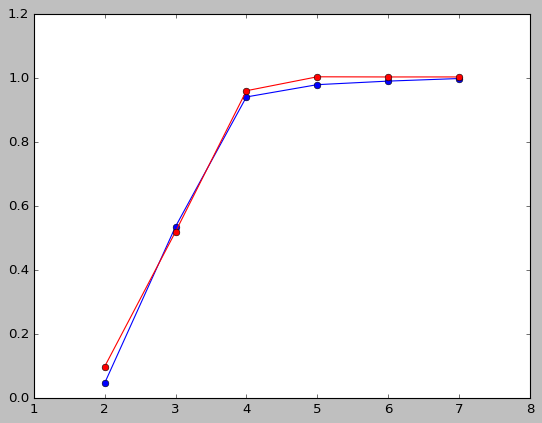

In [135]:
E1, E2, sat_m, not_change = sp.cao97(timeSeries=f_gsmoothed_101-f_gsmoothed_1001, tau=bestTauIdx, mMax=8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(2,8),E1, 'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(2,8),E2, 'ro',ls='-',label="E2 (==1 always for stochastic)")
ax.set_xlim(1,8)
plt.show()

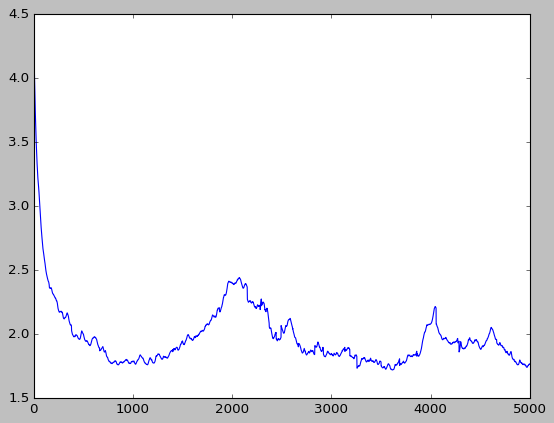

In [72]:
trialDelayIndices = np.arange(1,5000,1)
MI = np.zeros_like(trialDelayIndices,dtype='float')
for i,tau in enumerate(trialDelayIndices):
    MI[i] = sp.calc_MI(f_gsmoothed_1001[:-(tau+1)], f_gsmoothed_1001[(tau+1):],Xbins=sp.optimal_Nbins(f_gsmoothed_1001[:-(tau+1)]), Ybins = sp.optimal_Nbins(f_gsmoothed_1001[(tau+1):]))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(trialDelayIndices,MI,'b-')
plt.show()

In [91]:
5000/19.


263.1578947368421